### reading pcap files and prepare dataset

In [133]:
from scapy.all import *
import numpy as np
import pandas as pd
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # to ignore GPU
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, LeakyReLU, Conv1D, Conv2D, BatchNormalization, Dropout, Reshape, Permute, Flatten
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.optimizers import RMSprop

In [2]:
pkts_kali_train = rdpcap('data/OS-Fingerprinting/packets-kali-train.pcap')
print(pkts_kali_train)
pkts_kali_test = rdpcap('data/OS-Fingerprinting/packets-kali-test.pcap')
print(pkts_kali_test)

pkts_win10_train = rdpcap('data/OS-Fingerprinting/packets-win10-train.pcap')
print(pkts_win10_train)
pkts_win10_test = rdpcap('data/OS-Fingerprinting/packets-win10-test.pcap')
print(pkts_win10_test)

pkts_android_train = rdpcap('data/OS-Fingerprinting/packets-Android-train.pcap')
print(pkts_android_train)
pkts_android_test = rdpcap('data/OS-Fingerprinting/packets-Android-test.pcap')
print(pkts_android_test)

<packets-kali-train.pcap: TCP:21522 UDP:68 ICMP:0 Other:4>
<packets-kali-test.pcap: TCP:3645 UDP:97 ICMP:1 Other:4>
<packets-win10-train.pcap: TCP:27411 UDP:240 ICMP:1 Other:0>
<packets-win10-test.pcap: TCP:3828 UDP:126 ICMP:0 Other:0>
<packets-Android-train.pcap: TCP:3159 UDP:5917 ICMP:12 Other:0>
<packets-Android-test.pcap: TCP:2109 UDP:37 ICMP:0 Other:0>


In [3]:
def preprocess_packets(pkts, label):
    ihl, tos, length, flags_ip, ttl = [], [], [], [], []
    ack, dataofs, reserved, flags_tcp, window, urgptr = [], [], [], [], [], []
    OS = []

    for pkt in pkts: # loop through all captured packets
        if pkt.haslayer(TCP): # if it is a TCP packet
            # get IP header
            ihl.append(pkt[IP].ihl)
            tos.append(pkt[IP].tos)
            length.append(pkt[IP].len)
            flags_ip.append(str(pkt[IP].flags))
            ttl.append(pkt[IP].ttl)
            # get TCP header
            ack.append(pkt[TCP].ack)
            dataofs.append(pkt[TCP].dataofs)
            reserved.append(pkt[TCP].reserved)
            flags_tcp.append(str(pkt[TCP].flags))
            window.append(pkt[TCP].window)
            urgptr.append(pkt[TCP].urgptr)
            OS.append(label)

    data = {'ihl':ihl, 'tos':tos, 'length':length, 'flags_ip':flags_ip, 'ttl':ttl, 'ack':ack, 'dataofs':dataofs, 'reserved':reserved,
            'flags_tcp':flags_tcp, 'window':window, 'urgptr':urgptr, 'OS':OS}
    cols = ['ihl', 'tos', 'length', 'flags_ip', 'ttl', 'ack', 'dataofs', 'reserved', 'flags_tcp', 'window', 'urgptr', 'OS']
    df = pd.DataFrame(data=data, columns=cols)
    return df

In [4]:
OSes = {'win10':0, 'Kali':1, 'Android':2, 'MAC':3, 'IOS':4}

df_win10_train = preprocess_packets(pkts_win10_train, OSes['win10'])
df_win10_test = preprocess_packets(pkts_win10_test, OSes['win10'])
df_kali_train = preprocess_packets(pkts_kali_train, OSes['Kali'])
df_kali_test = preprocess_packets(pkts_kali_test, OSes['Kali'])
df_android_train = preprocess_packets(pkts_android_train, OSes['Android'])
df_android_test = preprocess_packets(pkts_android_test, OSes['Android'])
# other OSes

dfs_train = [df_win10_train, df_kali_train, df_android_train]
dfs_test = [df_win10_test, df_kali_test, df_android_test]

In [9]:
df_train = pd.concat(dfs_train, ignore_index=True)
df_test = pd.concat(dfs_test, ignore_index=True)

In [10]:
df_train.head()

,ihl,tos,length,flags_ip,ttl,ack,dataofs,reserved,flags_tcp,window,urgptr,OS
0,5,0,41,DF,128,1746802052,5,0,A,253,0,0
1,5,0,41,DF,128,2908417484,5,0,A,259,0,0
2,5,0,52,DF,128,0,8,0,S,64240,0,0
3,5,0,40,DF,128,4200334307,5,0,A,260,0,0
4,5,0,246,DF,128,4200334307,5,0,PA,260,0,0


In [11]:
df_train.describe()

,ihl,tos,length,ttl,ack,dataofs,reserved,window,urgptr,OS
count,52092.0,52092.000000,52092.000000,52092.000000,5.209200e+04,52092.000000,52092.0,52092.000000,52092.0,52092.000000
mean,5.0,0.027643,68.250595,97.677033,2.249613e+09,6.591607,0.0,8519.881863,0.0,0.534439
std,0.0,1.628820,138.333261,31.956332,1.411742e+09,1.869491,0.0,9492.359890,0.0,0.608364
min,5.0,0.000000,40.000000,64.000000,0.000000e+00,5.000000,0.0,0.000000,0.0,0.000000
25%,5.0,0.000000,40.000000,64.000000,8.672804e+08,5.000000,0.0,1131.000000,0.0,0.000000
50%,5.0,0.000000,52.000000,128.000000,1.715293e+09,5.000000,0.0,4320.000000,0.0,0.000000
75%,5.0,0.000000,52.000000,128.000000,3.559525e+09,8.000000,0.0,19466.000000,0.0,1.000000
max,5.0,96.000000,1426.000000,128.000000,4.255625e+09,15.000000,0.0,65535.000000,0.0,2.000000


### Preprocessing
- tos, reserved, and urgptr are always zero. ihl is always 5. Drop
- flags_ip and flags_tcp are text! convert to numbers using LabelEncoder
- normalize (scale to between zero and one) or standarize (zero mean and unit variance)

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_train = df_train.drop(['tos', 'reserved', 'urgptr', 'ihl'], axis=1)
df_test = df_test.drop(['tos', 'reserved', 'urgptr', 'ihl'], axis=1)

encoder_flags_ip = LabelEncoder()
new_col = encoder_flags_ip.fit_transform(df_train.flags_ip.values)
new_col_max = np.max(new_col)
new_col = new_col / new_col_max
df_train.flags_ip = new_col
new_col = encoder_flags_ip.transform(df_test.flags_ip.values)
new_col = new_col / new_col_max
df_test.flags_ip = new_col

encoder_flags_tcp = LabelEncoder()
new_col = encoder_flags_tcp.fit_transform(df_train.flags_tcp.values)
new_col_max = np.max(new_col)
new_col = new_col / new_col_max
df_train.flags_tcp = new_col
new_col = encoder_flags_tcp.transform(df_test.flags_tcp.values)
new_col = new_col / new_col_max
df_test.flags_tcp = new_col



scaler = StandardScaler()
scaler.fit(df_train.loc[:, ['length', 'ttl', 'ack', 'dataofs', 'window']].values.astype(np.float64))
df_train.loc[:, ['length', 'ttl', 'ack', 'dataofs', 'window']] = scaler.transform(df_train.loc[:, ['length', 'ttl', 'ack', 'dataofs', 'window']].values.astype(np.float64))
df_test.loc[:, ['length', 'ttl', 'ack', 'dataofs', 'window']] = scaler.transform(df_test.loc[:, ['length', 'ttl', 'ack', 'dataofs', 'window']].values.astype(np.float64))

In [14]:
df_train.describe()

,length,flags_ip,ttl,ack,dataofs,flags_tcp,window,OS
count,5.209200e+04,52092.000000,5.209200e+04,5.209200e+04,5.209200e+04,52092.000000,5.209200e+04,52092.000000
mean,-1.745939e-17,0.999866,1.396751e-16,1.222158e-16,-2.269721e-16,0.036570,-2.182424e-16,0.534439
std,1.000010e+00,0.011591,1.000010e+00,1.000010e+00,1.000010e+00,0.138927,1.000010e+00,0.608364
min,-2.042232e-01,0.000000,-1.053855e+00,-1.593517e+00,-8.513668e-01,0.000000,-8.975601e-01,0.000000
25%,-2.042232e-01,1.000000,-1.053855e+00,-9.791777e-01,-8.513668e-01,0.000000,-7.784105e-01,0.000000
50%,-1.174754e-01,1.000000,9.488967e-01,-3.784866e-01,-8.513668e-01,0.000000,-4.424529e-01,0.000000
75%,-1.174754e-01,1.000000,9.488967e-01,9.278785e-01,7.533636e-01,0.000000,1.153161e+00,1.000000
max,9.815155e+00,1.000000,9.488967e-01,1.420962e+00,4.497734e+00,1.000000,6.006480e+00,2.000000


### Split train & test

In [15]:
n_classes = 3

X_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:,-1].values
X_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:,-1].values
print(X_train.shape, X_test.shape)

# one hot encoding of the labels
y_train_one_hot = to_categorical(y_train, num_classes=n_classes)
y_test_one_hot = to_categorical(y_test, num_classes=n_classes)
print(y_train_one_hot.shape, y_test_one_hot.shape)

(52092, 7) (9582, 7)
(52092, 3) (9582, 3)


In [16]:
print(y_train.shape, y_test.shape)

(52092,) (9582,)


### Build the Model

In [98]:
input_dim = X_train.shape[1]

keras.backend.clear_session()
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=input_dim))
#model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
#model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(Dense(units=n_classes, activation='softmax'))

# If your targets are one-hot encoded, use categorical_crossentropy
# But if your targets are integers (or words), use sparse_categorical_crossentropy
model.compile(optimizer=RMSprop(lr=0.00002),
              loss=keras.losses.categorical_crossentropy,
              metrics=[categorical_accuracy])  # categorical_accuracy ?

# train
model.fit(X_train, y_train_one_hot, batch_size=128, epochs=12, validation_data=(X_test,y_test_one_hot))

Train on 52092 samples, validate on 9582 samples
Epoch 1/12
52092/52092 [==============================] - 1s 13us/step - loss: 1.0016 - categorical_accuracy: 0.4832 - val_loss: 1.0254 - val_categorical_accuracy: 0.3859
Epoch 2/12
52092/52092 [==============================] - 1s 10us/step - loss: 0.8432 - categorical_accuracy: 0.6513 - val_loss: 0.9406 - val_categorical_accuracy: 0.4172
Epoch 3/12
52092/52092 [==============================] - 1s 10us/step - loss: 0.7090 - categorical_accuracy: 0.7623 - val_loss: 0.8657 - val_categorical_accuracy: 0.5850
Epoch 4/12
52092/52092 [==============================] - 1s 10us/step - loss: 0.5894 - categorical_accuracy: 0.8295 - val_loss: 0.8014 - val_categorical_accuracy: 0.6332
Epoch 5/12
52092/52092 [==============================] - 1s 11us/step - loss: 0.4936 - categorical_accuracy: 0.8681 - val_loss: 0.7480 - val_categorical_accuracy: 0.6882
Epoch 6/12
52092/52092 [==============================] - 1s 10us/step - loss: 0.4143 - categori

[[3828    0    0]
 [   0 2954  691]
 [   0 1748  361]]


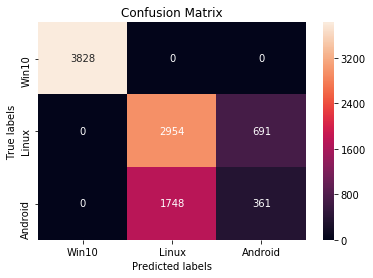

In [88]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict_classes(X_test)
#print(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Win10', 'Linux', 'Android']); ax.yaxis.set_ticklabels(['Win10', 'Linux', 'Android']);

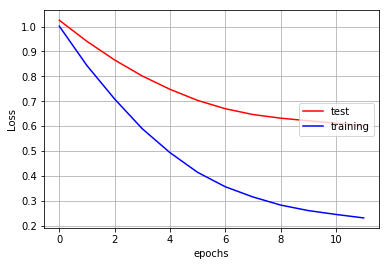

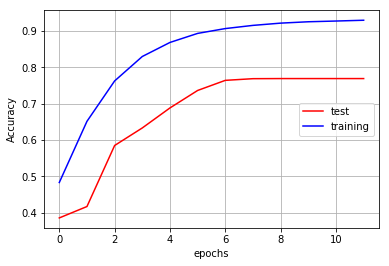

In [99]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(model):
    epochs = model.history.params['epochs']
    epochs = range(epochs)
    val_loss = model.history.history['val_loss']
    val_accuracy = model.history.history['val_categorical_accuracy']
    training_loss = model.history.history['loss']
    training_accuracy = model.history.history['categorical_accuracy']

    plt.plot(epochs, val_loss, 'r', label='test')
    plt.plot(epochs, training_loss, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(loc='center right')
    plt.grid(True)
    plt.show()

    plt.plot(epochs, val_accuracy, 'r', label='test')
    plt.plot(epochs, training_accuracy, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    plt.grid(True)
    plt.show()

plot_accuracy_and_loss(model)

In [46]:
model.save('./models/OS-Fingerprinting/no_seq.h5')
#keras.models.load_model

### sequence of packets

In [42]:
def create_seq_from_df(df, label, seq_len=20):
    seq_len = 20
    X = df[df.OS == label].iloc[:,:-1].values    
    old_data_len = X.shape[0]
    n_features = X.shape[1]
    n_samples = old_data_len - seq_len+1
    X_seq = np.zeros((n_samples, seq_len, n_features))
    for i in range(n_samples):
        for j in range(seq_len):
            X_seq[i,j,:] = X[i+j,:]
    y = np.ones((n_samples,), dtype=np.float64) * label
    y_one_hot = to_categorical(y, num_classes=n_classes)
    return X_seq, y, y_one_hot

def create_seq(X, seq_len=20):
    seq_len = 20
    old_data_len = X.shape[0]
    n_features = X.shape[1]
    n_samples = old_data_len - seq_len+1
    X_seq = np.zeros((n_samples, seq_len, n_features))
    for i in range(n_samples):
        for j in range(seq_len):
            X_seq[i,j,:] = X[i+j,:]
    return X_seq, (seq_len,n_features)

X_train_seq_win, y_train_seq_win, y_train_seq_one_hot_win = create_seq_from_df(df_train, 0, 20)
X_train_seq_kali, y_train_seq_kali, y_train_seq_one_hot_kali = create_seq_from_df(df_train, 1, 20)
X_train_seq_android, y_train_seq_android, y_train_seq_one_hot_android = create_seq_from_df(df_train, 2, 20)
X_train_seq = np.concatenate((X_train_seq_win,X_train_seq_kali,X_train_seq_android), axis=0)
y_train_seq = np.concatenate((y_train_seq_win,y_train_seq_kali,y_train_seq_android), axis=0)
y_train_seq_one_hot = np.concatenate((y_train_seq_one_hot_win,y_train_seq_one_hot_kali,y_train_seq_one_hot_android), axis=0)

X_test_seq_win, y_test_seq_win, y_test_seq_one_hot_win = create_seq_from_df(df_test, 0, 20)
X_test_seq_kali, y_test_seq_kali, y_test_seq_one_hot_kali = create_seq_from_df(df_test, 1, 20)
X_test_seq_android, y_test_seq_android, y_test_seq_one_hot_android = create_seq_from_df(df_test, 2, 20)
X_test_seq = np.concatenate((X_test_seq_win,X_test_seq_kali,X_test_seq_android), axis=0)
y_test_seq = np.concatenate((y_test_seq_win,y_test_seq_kali,y_test_seq_android), axis=0)
y_test_seq_one_hot = np.concatenate((y_test_seq_one_hot_win,y_test_seq_one_hot_kali,y_test_seq_one_hot_android), axis=0)


#X_test_seq, y_test_seq, y_test_seq_one_hot, _ = create_seq(X_test)
print(X_train_seq.shape, y_train_seq.shape, y_train_seq_one_hot.shape)
print(X_test_seq.shape, y_test_seq.shape, y_test_seq_one_hot.shape)

(52035, 20, 7) (52035,) (52035, 3)
(9525, 20, 7) (9525,) (9525, 3)


In [121]:
input_shape = X_train_seq.shape[1:]

keras.backend.clear_session()
model_seq = Sequential()
model_seq.add(LSTM(140, input_shape=input_shape)) # , dropout=0.2, recurrent_dropout=0.2
#model_seq.add(BatchNormalization())
model_seq.add(Dense(units=222, activation='relu'))
#model_seq.add(Dropout(0.4))
#model_seq.add(BatchNormalization())
model_seq.add(Dense(units=n_classes, activation='softmax'))

model_seq.summary()

# If your targets are one-hot encoded, use categorical_crossentropy
# But if your targets are integers (or words), use sparse_categorical_crossentropy
model_seq.compile(optimizer=RMSprop(lr=0.000005),
              loss=keras.losses.categorical_crossentropy,
              metrics=[categorical_accuracy])

# train
model_seq.fit(X_train_seq, y_train_seq_one_hot, batch_size=128, epochs=12, validation_data=(X_test_seq,y_test_seq_one_hot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 140)               82880     
_________________________________________________________________
dense_1 (Dense)              (None, 222)               31302     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 669       
Total params: 114,851
Trainable params: 114,851
Non-trainable params: 0
_________________________________________________________________
Train on 52035 samples, validate on 9525 samples
Epoch 1/12
52035/52035 [==============================] - 17s 318us/step - loss: 0.8743 - categorical_accuracy: 0.9280 - val_loss: 0.9160 - val_categorical_accuracy: 0.7604
Epoch 2/12
52035/52035 [==============================] - 16s 299us/step - loss: 0.6180 - categorical_accuracy: 0.9335 - val_loss: 0.7421 - val_categorical_accuracy: 0.7694
Epoch

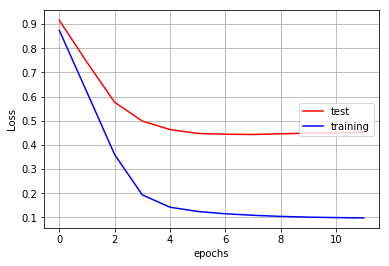

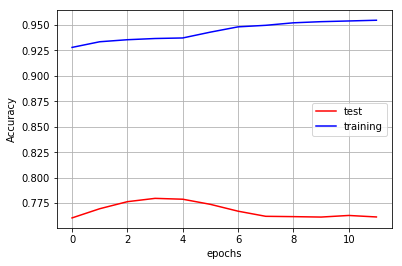

In [122]:
plot_accuracy_and_loss(model_seq)

### CONV(32,4,2,1,V) - BN - CONV(64,4,2,1,V) - BN - LSTM(100) - DP(0.2) - FC(100) - DP(0.4)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
X_train_seq.shape[1:]

In [162]:
input_shape = X_train_seq.shape[1:] + (1,)

keras.backend.clear_session()
model2a = Sequential()
#odel2a.add(Reshape((20, 7, 1)))
model2a.add(Conv2D(24, kernel_size=(3,7), strides=1, data_format='channels_last', activation='relu', input_shape=input_shape))
#model2a.add(LeakyReLU(alpha=0.3))
#model2a.add(BatchNormalization())
model2a.add(Reshape((18,24)))
#model2a.add(Flatten())
#model2a.summary()
#model.add(Permute(()))
#model2a.add(Conv2D(64, kernel_size=(4,7), strides=1, data_format='channels_last', activation='relu'))
#model2a.add(LeakyReLU(alpha=0.3))
#model2a.add(BatchNormalization())
#model2a.summary()
model2a.add(LSTM(22)) # , dropout=0.2, recurrent_dropout=0.2
model2a.add(Dense(666, activation='relu'))
model2a.add(Dropout(0.4))
model2a.add(Dense(units=n_classes, activation='softmax'))

model2a.summary()

# If your targets are one-hot encoded, use categorical_crossentropy
# But if your targets are integers (or words), use sparse_categorical_crossentropy
model2a.compile(optimizer=keras.optimizers.Adagrad(lr=0.0003),
              loss=keras.losses.categorical_crossentropy,
              metrics=[categorical_accuracy])

# train
model2a.fit(X_train_seq.reshape(X_train_seq.shape+(1,)), y_train_seq_one_hot, batch_size=1024, epochs=22, validation_data=(X_test_seq.reshape(X_test_seq.shape+(1,)),y_test_seq_one_hot))
# .reshape(X_train_seq.shape + (1,))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 1, 24)         528       
_________________________________________________________________
reshape_1 (Reshape)          (None, 18, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 22)                4136      
_________________________________________________________________
dense_1 (Dense)              (None, 666)               15318     
_________________________________________________________________
dropout_1 (Dropout)          (None, 666)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2001      
Total params: 21,983
Trainable params: 21,983
Non-trainable params: 0
_________________________________________________________________
Train 

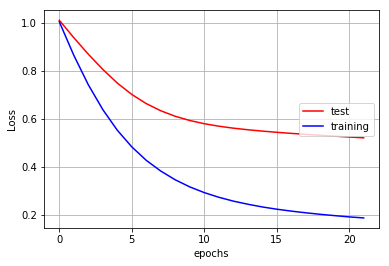

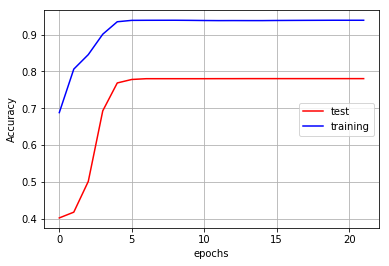

In [163]:
plot_accuracy_and_loss(model2a)

In [132]:
model2a.save('./models/OS-Fingerprinting/model2a_1.h5')
#keras.models.load_model